📸 Please upload an image (preferably with clear shapes):


Saving u23.jpg to u23.jpg


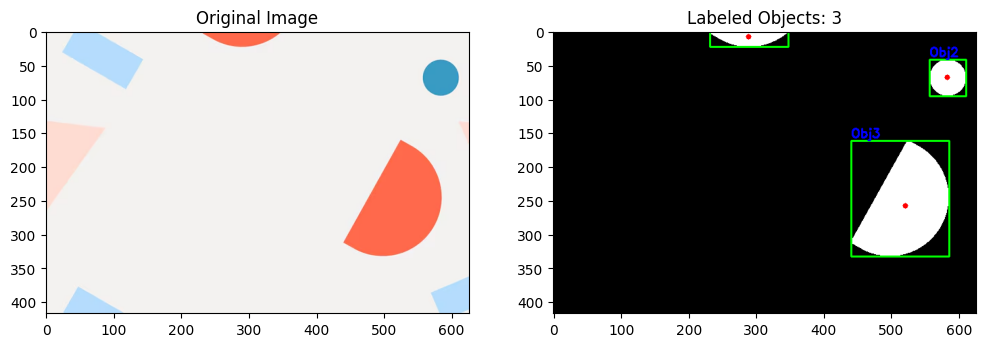


🧮 Object Analysis Summary:
   Object ID   Area   Perimeter Centroid (x,y)
0          1   1916  249.396968       (289, 8)
1          2   2268  175.681239      (583, 68)
2          3  15111  510.256922     (521, 258)


In [ ]:
# UNIT 2 - Enhanced Shape and Region Analysis
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd

print("📸 Please upload an image (preferably with clear shapes):")
uploaded = files.upload()

# Load uploaded image
for fn in uploaded.keys():
    img = cv2.imread(fn)

# Step 1: Preprocess
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)
_, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Invert if needed (to make objects white)
if np.sum(binary == 255) > np.sum(binary == 0):
    binary = cv2.bitwise_not(binary)

# Step 2: Connected Component Analysis
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
output = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

# Step 3: Analyze Each Object
data = []
for i in range(1, num_labels):  # Skip background
    area = stats[i, cv2.CC_STAT_AREA]
    x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]

    # Create mask for contour extraction
    mask = np.uint8(labels == i)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    perimeter = cv2.arcLength(contours[0], True)

    cx, cy = int(centroids[i][0]), int(centroids[i][1])
    cv2.rectangle(output, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.circle(output, (cx, cy), 4, (0, 0, 255), -1)
    cv2.putText(output, f"Obj{i}", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

    data.append([i, area, perimeter, (cx, cy)])

# Step 4: Display Results
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title(f"Labeled Objects: {num_labels-1}")
plt.show()

# Step 5: Show Summary Table
df = pd.DataFrame(data, columns=["Object ID", "Area", "Perimeter", "Centroid (x,y)"])
print("\n🧮 Object Analysis Summary:")
print(df)


📸 Please upload an image (coins, shapes, etc.):


Saving u323.png to u323.png


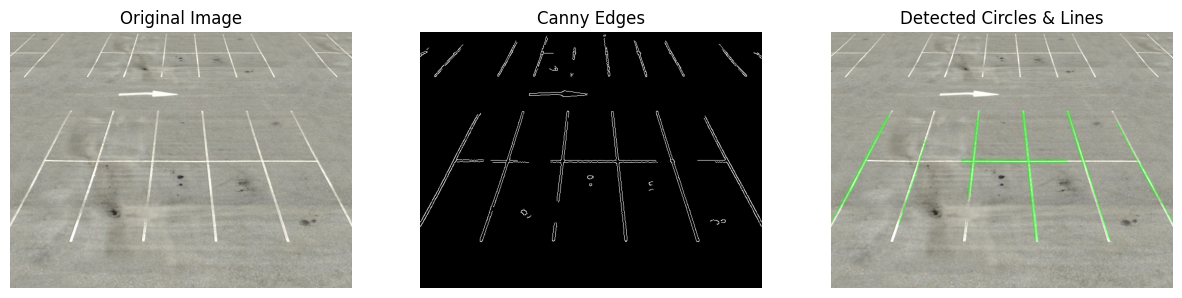

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

print("📸 Please upload an image (coins, shapes, etc.):")
uploaded = files.upload()

for fn in uploaded.keys():
    img = cv2.imread(fn)

# Convert to grayscale and blur to remove noise
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 5)

# Edge detection (for visualization)
edges = cv2.Canny(gray, 80, 150)

# --- Hough Line Detection (optional) ---
line_output = img.copy()
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
if lines is not None:
    for x1, y1, x2, y2 in lines[:,0]:
        cv2.line(line_output, (x1, y1), (x2, y2), (0, 255, 0), 2)

# --- Hough Circle Detection (tuned) ---
circle_output = img.copy()
circles = cv2.HoughCircles(
    gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=80,  # Keep circles separate
    param1=100, param2=40,                         # param2 ↑ = fewer false circles
    minRadius=30, maxRadius=70                     # adjust based on object size
)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for (x, y, r) in circles[0, :]:
        cv2.circle(circle_output, (x, y), r, (255, 0, 0), 3)
        cv2.circle(circle_output, (x, y), 3, (0, 0, 255), -1)

# Combine both outputs (optional)
combined = cv2.addWeighted(line_output, 0.5, circle_output, 0.5, 0)

# Display
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image"); axs[0].axis('off')

axs[1].imshow(edges, cmap='gray')
axs[1].set_title("Canny Edges"); axs[1].axis('off')

axs[2].imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
axs[2].set_title("Detected Circles & Lines"); axs[2].axis('off')

plt.show()

🎞️ Please upload a short video file (MP4/AVI, under 10–20 MB recommended):


Saving 20251018_135745.mp4 to 20251018_135745 (2).mp4
✅ Processed video — showing 7 key motion frames


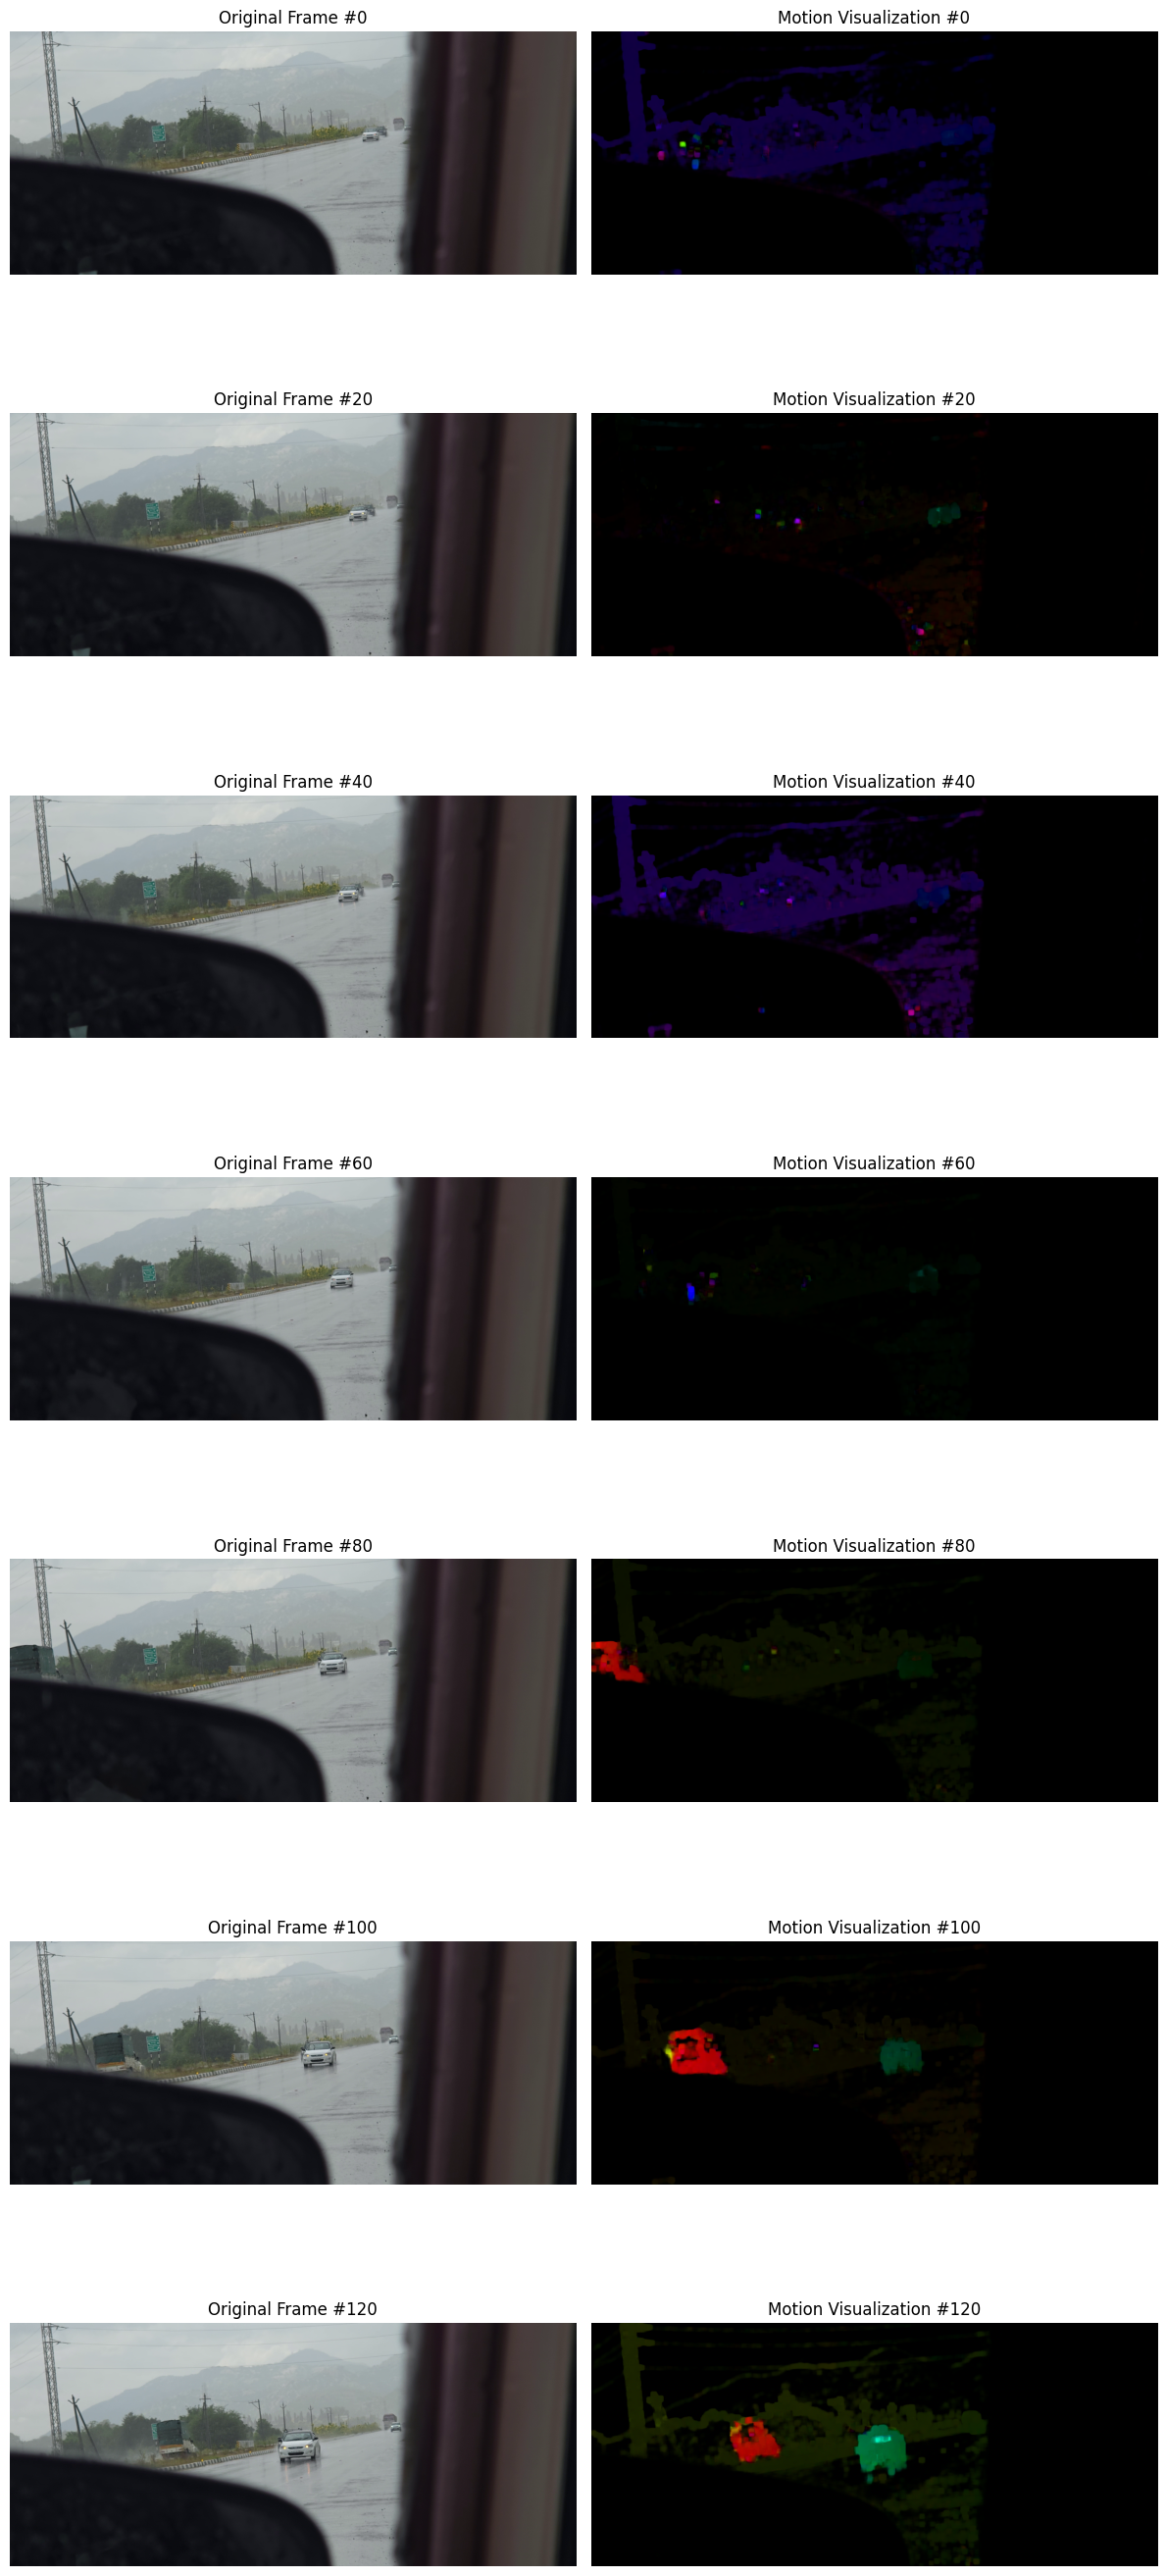

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

print("🎞️ Please upload a short video file (MP4/AVI, under 10–20 MB recommended):")
uploaded = files.upload()

# Load uploaded video
for fn in uploaded.keys():
    video_path = fn

# Open video
cap = cv2.VideoCapture(video_path)
ret, prev = cap.read()
if not ret:
    raise ValueError("Could not read the video. Please upload a valid one.")

prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(prev)
hsv[..., 1] = 255

frame_idx = 0
snapshots = []  # store a few motion maps

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Save every 20th frame for display
    if frame_idx % 20 == 0:
        snapshots.append((frame.copy(), rgb.copy()))
    prev_gray = gray

cap.release()

# Display few sample frames with motion
print(f"✅ Processed video — showing {len(snapshots)} key motion frames")

cols = 2
rows = len(snapshots)
plt.figure(figsize=(12, 4 * rows))

for i, (orig, motion) in enumerate(snapshots):
    plt.subplot(rows, cols, 2*i + 1)
    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Frame #{i*20}")
    plt.axis('off')

    plt.subplot(rows, cols, 2*i + 2)
    plt.imshow(motion)
    plt.title(f"Motion Visualization #{i*20}")
    plt.axis('off')

plt.tight_layout()
plt.show()


🚶 Upload a street image with pedestrians:


Saving u5u5.jpg to u5u5.jpg


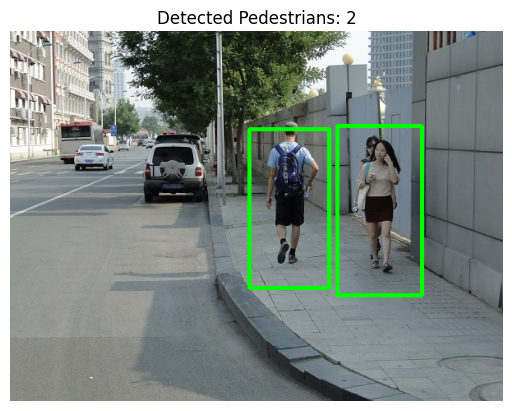

In [ ]:
# UNIT 5 – Pedestrian Detection using HOG
import cv2, matplotlib.pyplot as plt
from google.colab import files

print("🚶 Upload a street image with pedestrians:")
uploaded = files.upload()
for fn in uploaded.keys():
    image = cv2.imread(fn)

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

(rects, weights) = hog.detectMultiScale(image, winStride=(4, 4),
                                        padding=(8, 8), scale=1.05)

for (x, y, w, h) in rects:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 3)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Pedestrians: {len(rects)}")
plt.axis('off')
plt.show()